# Installations and setup, from: 
#### https://colab.research.google.com/github/PriorLabs/TabPFN/blob/main/examples/notebooks/TabPFN_Demo_Local.ipynb

In [2]:
import os
os.environ["TABPFN_ALLOW_CPU_LARGE_DATASET"] = "true"  # or "1"

In [3]:
## Base library Installation
# Install Baselines for model comparison
!pip install catboost xgboost

# Install the datasets library for loading example data
!pip install datasets

# Install rich for better and more readable printing
!pip install rich

## TabPFN Installation optimized for Google Colab
# Install the TabPFN Client library
!pip install tabpfn-client

# Install TabPFN extensions for additional functionalities
!pip install tabpfn-extensions[all]

# Install tabpfn
!pip install tabpfn

  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (47.7 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 20.0.0
    Uninstalling pyarrow-20.0.0:
      Successfully uninstalled pyarrow-20.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-common 1.4.0 requires pyarrow<21.0.0,>=7.0.0, but you have pyarrow 22.0.0 which is incompatible.
  Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (42.3 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 22.0.0
    Uninstalling pyarrow-22.0.0:
      Successfully uninstalled pyarrow-22.0.0
ERROR: pip's dependency resolver does not currently take into account all th

In [4]:
# TabPFN and Extensions
try:
    from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
        AutoTabPFNClassifier,
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor
except ImportError:
    raise ImportError(
        "Warning: Could not import TabPFN / TabPFN extensions. Please run installation above and restart the session afterwards (Runtime > Restart Session)."
    )

# Data Science & Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Notebook UI/Display
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule
from sklearn.compose import make_column_selector, make_column_transformer

# Scikit-Learn: Data & Preprocessing
from sklearn.datasets import fetch_openml, load_breast_cancer

# Scikit-Learn: Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor

# This transformer will be used to handle categorical features for the baseline models
column_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_include=["object", "category"]),
    ),
    remainder="passthrough",
)

/srv/conda/envs/notebook/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Setting up tab

In [5]:
from tabpfn import TabPFNClassifier
print("TabPFNClassifier imported successfully.")

TabPFNClassifier imported successfully.


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv("FPA-FOD_39attributes.csv", low_memory=False)

unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"
df_known = df[~unknown_mask].copy()

# Drop 2 smallest classes (full dataset exceeds number of classes supported by TabPFN)
cause_counts = df_known['NWCG_GENERAL_CAUSE'].value_counts()
classes_to_drop = cause_counts.nsmallest(2).index.tolist()
classes_to_drop.append("Unnamed: 0")
df_reduced = df_known[~df_known['NWCG_GENERAL_CAUSE'].isin(classes_to_drop)].copy()

In [7]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in cast")

from sklearn.preprocessing import MinMaxScaler
import numpy as np

X = df_reduced.drop(columns=['NWCG_GENERAL_CAUSE', 'Unnamed: 0'])
y = df_reduced['NWCG_GENERAL_CAUSE']

# Encode y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert all categoricals
categorical_cols = ['STATE', 'Mang_Name', 'FIPS_CODE']
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Scale numerics to [0,1] (eliminates embedding NaNs)
numeric_cols = X.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

#Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Categorical:", sum(X_train.dtypes == 'category'))
print("Numeric:", sum(X_train.dtypes != 'category'))

Categorical: 3
Numeric: 36


In [8]:
tabpfn_classifier = TabPFNClassifier(random_state=42, ignore_pretraining_limits=True)
tabpfn_classifier.fit(X_train, y_train)

y_pred_train = tabpfn_classifier.predict_proba(X_train)
y_pred_test = tabpfn_classifier.predict_proba(X_test)

print("✅ Train preds:", y_pred_train.shape)
print("✅ Test preds:", y_pred_test.shape)

✅ Train preds: (6103, 10)
✅ Test preds: (1526, 10)


In [9]:
roc_auc_score(y_test, y_pred_test, multi_class='ovr')

np.float64(0.8878688831776925)

In [10]:
y_pred = tabpfn_classifier.predict(X_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Weighted metrics
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1 = report['weighted avg']['f1-score']
accuracy = accuracy_score(y_test, y_pred)

print("=== TABPFN WILDFIRE RESULTS (10 CLASSES) ===")
print(f"Accuracy:           {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print(f"Weighted F1:        {weighted_f1:.4f}")

=== TABPFN WILDFIRE RESULTS (10 CLASSES) ===
Accuracy:           0.7313
Weighted Precision: 0.6730
Weighted Recall:    0.7313
Weighted F1:        0.6924


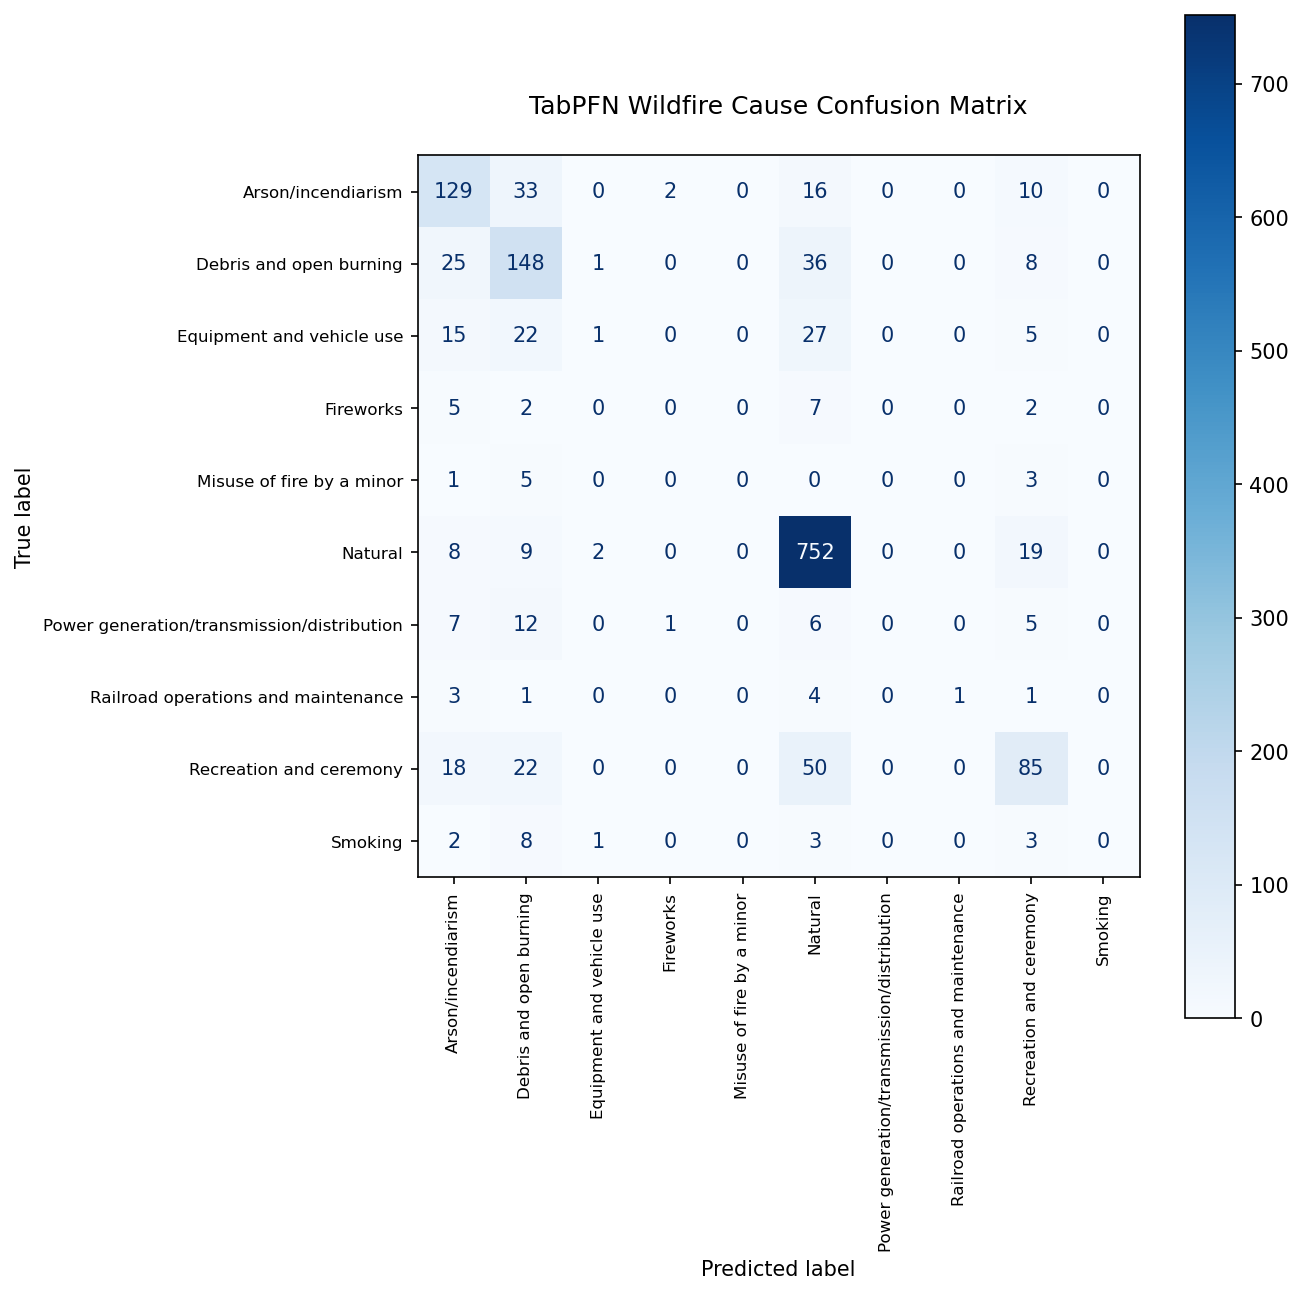

In [12]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(9, 9), dpi=150)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))
)
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format=".0f")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title('TabPFN Wildfire Cause Confusion Matrix', fontsize=12, pad=20)
plt.tight_layout()
plt.savefig('tabpfn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Natural vs human accuarcy
natural_idx = np.where(label_encoder.classes_ == 'Natural')[0][0]  # Find Natural class index
y_test_binary = (y_test == natural_idx).astype(int)  # 1=Natural, 0=Human
y_pred_binary = (y_pred == natural_idx).astype(int)

natural_human_accuracy = accuracy_score(y_test_binary, y_pred_binary)

print(f"Natural vs Human:   {natural_human_accuracy:.4f}")

Natural vs Human:   0.8775


In [20]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import entropy
uncertainties = entropy(y_pred_test, axis=1)  # Higher = more uncertain

correct = (tabpfn_classifier.predict(X_test) == y_test)

print(f"Avg top-1 prob:  {np.mean(top1_prob):.3f}")
print(f"Calibrated:       {np.corrcoef(uncertainties, correct.astype(int))[0,1]:.3f}")

Avg top-1 prob:  0.733
Calibrated:       -0.528


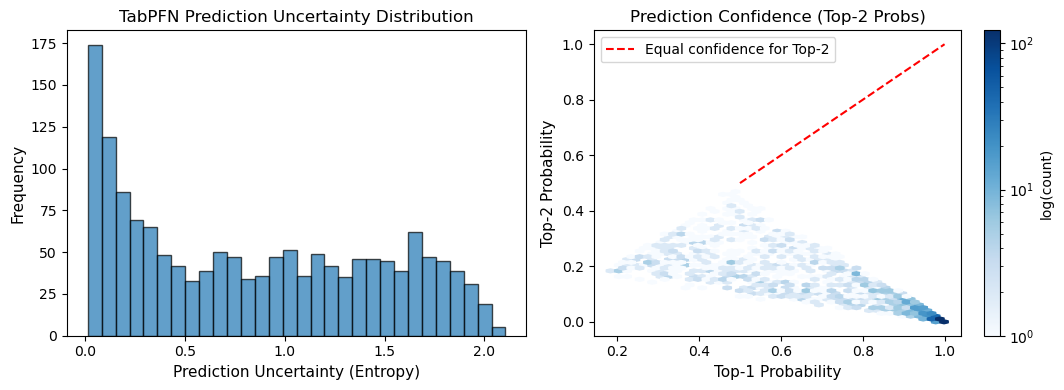

In [24]:
plt.figure(figsize=(16, 4))  # wider figure

# 1. Uncertainty histogram
plt.subplot(1, 3, 1)
plt.hist(uncertainties, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Uncertainty (Entropy)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('TabPFN Prediction Uncertainty Distribution', fontsize=12)

# 2. Top-2 probabilities (confidence)
top1_prob = np.max(y_pred_test, axis=1)
top2_prob = np.partition(y_pred_test, -2, axis=1)[:, -2]

plt.subplot(1, 3, 2)
hb = plt.hexbin(top1_prob, top2_prob, gridsize=40, cmap='Blues', bins='log')
plt.plot([0.5, 1], [0.5, 1], 'r--', label='Equal confidence for Top-2')
plt.xlabel('Top-1 Probability', fontsize=11)
plt.ylabel('Top-2 Probability', fontsize=11)
plt.title('Prediction Confidence (Top-2 Probs)', fontsize=12)
plt.colorbar(hb, label='log(count)')
plt.legend()

plt.tight_layout()  # <-- spreads things out nicely
plt.show()

                                     Cause Mean entropy Mean top-1 prob  N fires
                                   Natural        0.470           0.871      790
                   Debris and open burning        1.110           0.637      218
                        Arson/incendiarism        1.137           0.616      190
                   Recreation and ceremony        1.255           0.577      175
                 Equipment and vehicle use        1.425           0.511       70
                                 Fireworks        1.458           0.495       16
       Railroad operations and maintenance        1.527           0.466       10
Power generation/transmission/distribution        1.552           0.460       31
                 Misuse of fire by a minor        1.604           0.438        9
                                   Smoking        1.717           0.382       17


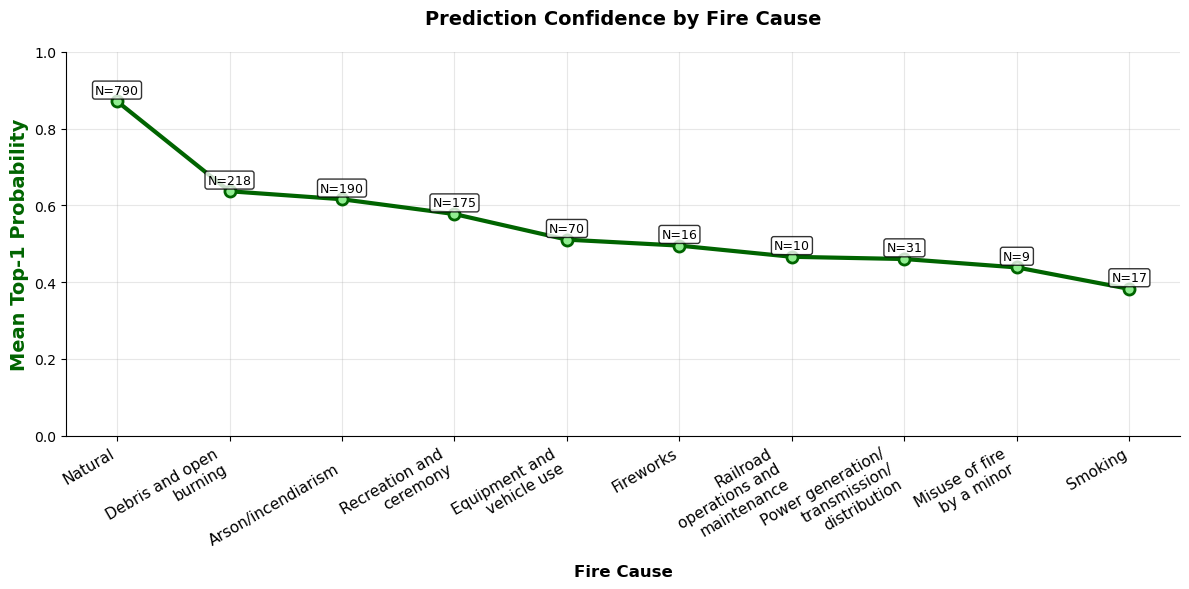

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy

class_names = list(label_encoder.classes_)

uncertainties = entropy(y_pred_test, axis=1)
top1_prob = np.max(y_pred_test, axis=1)

rows = []
for c in np.unique(y_test):
    mask = (y_test == c)
    rows.append({
        "Cause": class_names[int(c)],            # map index -> name
        "Mean entropy": uncertainties[mask].mean(),
        "Mean top-1 prob": top1_prob[mask].mean(),
        "N fires": int(mask.sum())
    })

df_true = pd.DataFrame(rows).sort_values("Mean entropy")

df_display = df_true.copy()
df_display["Mean entropy"] = df_display["Mean entropy"].map(lambda x: f"{x:.3f}")
df_display["Mean top-1 prob"] = df_display["Mean top-1 prob"].map(lambda x: f"{x:.3f}")

print(df_display.to_string(index=False))

# Line chart: Prediction confidence by cause
def wrap_label(label, width=15):
    words = label.split()
    lines, current = [], []
    for w in words:
        if len(" ".join(current + [w])) <= width:
            current.append(w)
        else:
            lines.append(" ".join(current))
            current = [w]
    if current:
        lines.append(" ".join(current))
    return "\n".join(lines)

wrapped_causes = [wrap_label(cause, width=15) for cause in df_true["Cause"]]

wrapped_causes = [
    ("Power generation/transmission/distribution" in orig
     and "Power generation/\ntransmission/\ndistribution")
    or lab
    for orig, lab in zip(df_true["Cause"], wrapped_causes)
]

plt.figure(figsize=(12, 6))
plt.plot(range(len(df_true)), df_true["Mean top-1 prob"], 'o-',
         linewidth=3, markersize=8, color='darkgreen',
         markerfacecolor='lightgreen', markeredgewidth=2)

plt.xticks(
    range(len(df_true)),
    wrapped_causes,
    rotation=30,
    ha='right',
    fontsize=11
)

plt.ylabel("Mean Top-1 Probability", fontsize=14, fontweight='bold', color='darkgreen')
plt.xlabel("Fire Cause", fontsize=12, fontweight='bold')
plt.title("Prediction Confidence by Fire Cause", fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for i, (idx, row) in enumerate(df_true.iterrows()):
    plt.annotate(
        f'N={int(row["N fires"])}',
        (i, row["Mean top-1 prob"] + 0.02),
        ha='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()